In [32]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import numpy as np
from laplace.baselaplace import FullLaplace, BaseLaplace
from laplace.curvature.backpack import BackPackGGN
from laplace import Laplace, marglik_training

In [33]:
def get_heteroscedastic_example(n_data=150,batch_size=150):
    torch.manual_seed(42)
    x_lin = torch.linspace(-1, 1, n_data)
    x_train = x_lin.unsqueeze(-1)
    f = lambda x: 0.5 * x**2 + 0.25 * x**3
    eps = torch.randn(n_data) * (0.1 + 0.4 * x_lin)
    y = f(x_lin) + eps
    y_train = y.unsqueeze(-1)
    train_loader_hetero = data_utils.DataLoader(
        data_utils.TensorDataset(x_train, y_train), 
        batch_size=batch_size
    )
    x_test = torch.linspace(-1, 1, 500).unsqueeze(-1)
    return x_train, y_train, train_loader_hetero, x_test

In [34]:
def plot_data(X_train, y_train, X_test=None, y_test=None, samples=None):
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train.numpy(), y_train.numpy())
    if X_test is not None:
        plt.plot(X_test.numpy(), y_test.numpy(), color='k')
    if samples is not None:
        plt.plot(X_test.numpy(), samples.numpy(), color='r', alpha=0.2)
    plt.show()

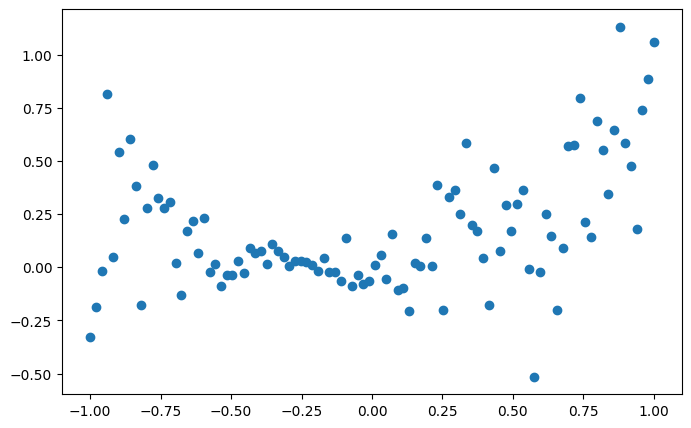

In [35]:
x_train, y_train, train_loader_hetero, x_test = get_heteroscedastic_example(n_data=100, batch_size=100)

plot_data(x_train, y_train)

In [36]:
prior_mean_1 = -3
prior_std_1 = 1
prior_mean_0 = 2
prior_std_0 = 1

prior_dist_1 = torch.distributions.Normal(prior_mean_1, prior_std_1)
prior_dist_0 = torch.distributions.Normal(prior_mean_0, prior_std_0)

In [44]:
# define a simple linear regression model with the name LinearRegressionModel

class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)
    
    def log_likelihood(self, x, y):
        y_pred = self.forward(x).squeeze(-1)
        return torch.distributions.Normal(y_pred, 0.01).log_prob(y).sum()
    
    def log_prior(self):
        return prior_dist_1.log_prob(self.linear.weight).sum() + prior_dist_0.log_prob(self.linear.bias).sum()
    
    def log_posterior(self, x, y):
        return self.log_likelihood(x, y) + self.log_prior()
    

In [25]:
class HeteroskedasticNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 2)

    def forward(self, x):
        z = self.linear(x)
        mu_hat = z[:, 0]
        log_noise_std = z[:, 1]
        return mu_hat, log_noise_std
    
    def log_likelihood(self, x, y):
        mu_hat, log_noise_std = self.forward(x)
        return torch.distributions.Normal(mu_hat, log_noise_std.exp()).log_prob(y).sum()
    
    def log_prior(self):
        # print(self.linear.weight[0])
        # print(self.linear.bias[0])
        return prior_dist_1.log_prob(self.linear.weight[0]).sum() + prior_dist_0.log_prob(self.linear.bias[0]).sum()
    
    def log_posterior(self, x, y):
        return self.log_likelihood(x, y) + self.log_prior()

In [45]:
model = LinearRegressionModel()

In [26]:
model = HeteroskedasticNN()
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1564],
        [-0.8799]], requires_grad=True)
Parameter containing:
tensor([-0.4309, -0.5987], requires_grad=True)


In [46]:
n_epochs = 1000

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader_hetero:
        optimizer.zero_grad()
        loss = -model.log_posterior(X,y)
        loss.backward()
        optimizer.step()


In [31]:
for X,y in train_loader_hetero:
    print("X: ",X)
    print("y: ",y)
    # print(model.log_posterior(X,y))
    # break

X:  tensor([[-1.0000],
        [-0.9798],
        [-0.9596],
        [-0.9394],
        [-0.9192],
        [-0.8990],
        [-0.8788],
        [-0.8586],
        [-0.8384],
        [-0.8182],
        [-0.7980],
        [-0.7778],
        [-0.7576],
        [-0.7374],
        [-0.7172],
        [-0.6970],
        [-0.6768],
        [-0.6566],
        [-0.6364],
        [-0.6162],
        [-0.5960],
        [-0.5758],
        [-0.5556],
        [-0.5354],
        [-0.5152],
        [-0.4949],
        [-0.4747],
        [-0.4545],
        [-0.4343],
        [-0.4141],
        [-0.3939],
        [-0.3737],
        [-0.3535],
        [-0.3333],
        [-0.3131],
        [-0.2929],
        [-0.2727],
        [-0.2525],
        [-0.2323],
        [-0.2121],
        [-0.1919],
        [-0.1717],
        [-0.1515],
        [-0.1313],
        [-0.1111],
        [-0.0909],
        [-0.0707],
        [-0.0505],
        [-0.0303],
        [-0.0101],
        [ 0.0101],
        [ 0.0303],
        

In [28]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-7.5611e-05],
        [-6.0768e-08]], requires_grad=True)
Parameter containing:
tensor([ 0.1720, -1.2284], requires_grad=True)


In [47]:
la_hetero = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la_hetero.fit(train_loader_hetero)

In [48]:
def plot_regression(X_train, y_train, X_test, f_test, y_std, plot=True, 
                    file_name='regression_example'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                                figsize=(8, 4))
    ax1.set_title('MAP')
    ax1.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax1.plot(X_test, f_test, color='black', label='$f_{MAP}$')
    ax1.legend()

    ax2.set_title('LA')
    ax2.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax2.plot(X_test, f_test, label='$\mathbb{E}[f]$')
    ax2.fill_between(X_test, f_test-y_std*2, f_test+y_std*2, 
                     alpha=0.3, color='tab:blue', label='$2\sqrt{\mathbb{V}\,[y]}$')
    ax2.legend()
    # ax1.set_ylim([0, 30])
    ax1.set_xlim([X_test.min(), X_test.max()])
    ax2.set_xlim([X_test.min(), X_test.max()])
    ax1.set_ylabel('$y$')
    ax1.set_xlabel('$x$')
    ax2.set_xlabel('$x$')
    plt.tight_layout()
    if plot:
        plt.show()

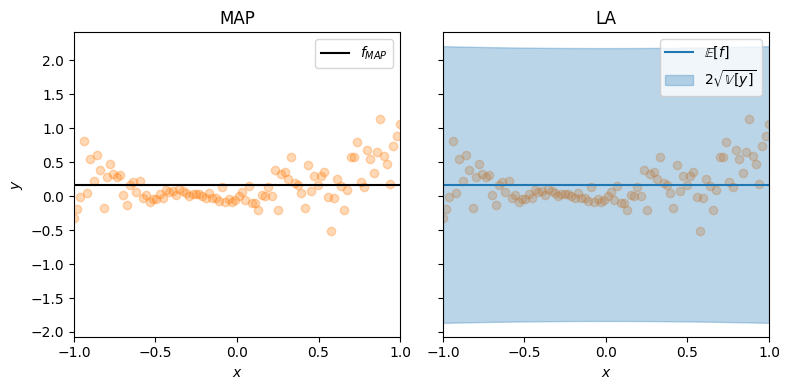

In [49]:
x = x_test.flatten().cpu().numpy()
f_mu, f_var = la_hetero(x_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la_hetero.sigma_noise.item()**2)

plot_regression(x_train, y_train, x, f_mu, pred_std)